This notebook is only focusing on Milestone 1 sample.

This notebook focus on the following criteria
1. Linear, GAM, rules, forest (baseline)
1. 30-fold CV error rate and log loss


In [1]:
import data1 as data
import random
from common import *
from rules import *
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Full phase prediction


In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)
lr_chain = ClassifierChain(lr, order=[0, 1, 2])
lr_pcc = ProbabilisticClassifierChain(lr) 

# gams not fixed, remove this part.
# gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=20.0, max_iter=250))
# gam_chain = ClassifierChain(LogisticGAM(lam=20.0, max_iter=250))
# gam_pcc = ProbabilisticClassifierChain(LogisticGAM(lam=20.0, max_iter=250))

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1])
rf_pcc = ProbabilisticClassifierChain(rf)

# Rulefit
rufit_pcc = RuleFitWrapper()

full_estimators = [lr_ind, lr_pcc, rf_ind, rf_pcc, rufit_pcc]
full_names = ['LR_ind', 'LR_pcc', 'RF_ind', 'RF_pcc', 'rufit_pcc']

# indi_estimators = [lr_ind, lr_pcc, rf_ind, rf_pcc, rufit, gam_ind, gam_pcc]
# indi_names = ['LR_ind', 'LR_pcc', 'RF_ind', 'RF_pcc', 'Rule_fit', 'Gam_ind', 'gam_pcc']

This following code under "2.6 GHz 6-Core Intel Core i7" runs ~5 hours. You can simply use saved result to re-run the result.

In [4]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold

interpolation = Experiment(full_estimators, 
                    full_names,
                    KFold(30, shuffle=True, random_state=STATE),
                    data.x, data.y.replace(-1.0, 0.0),
                    groups=data.comp_ids.array, 
                    evaluators=['accuracy', LogLikelihoodEvaluator(2, neg=True)],
                    verbose=True).run()

Running experiment with 30 repetitions
******************************


In [16]:
# save models in directory, remove comment to use it.
# cur_save=open('./' + 'interpolation_30folder' + '.p', 'wb')
# pickle.dump(interpolation, cur_save, -1)
# cur_save.close()
# cur_save=open('./' + 'interpolation_30folder' + '.p', 'rb')
# interpolation = pickle.load(cur_save)

We can find the rufit model is comparable with random forest.

In [5]:
interpolation.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_pcc,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
RF_ind,0.999825,0.000533,0.788860,0.075846,0.256396,0.004974,1.140403,0.702724
RF_pcc,0.999243,0.001186,0.792105,0.069495,0.245991,0.003946,1.087693,0.697455
rufit_pcc,0.985149,0.015632,0.788684,0.076686,0.157473,0.118493,1.291236,0.753052


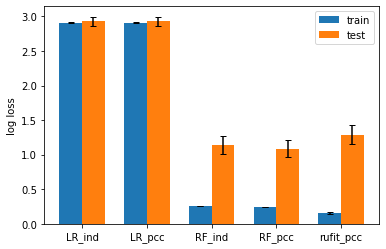

In [15]:
interpolation.plot_summary('log loss')

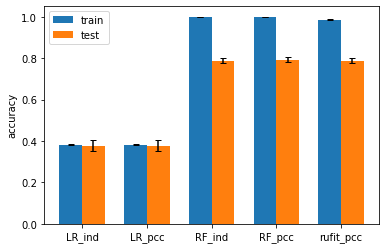

In [7]:
interpolation.plot_summary('accuracy')

### Extrapolation

In [ ]:
from common import ExtrapolationExperiment, sample_size, GroupDescription
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score

extrapolation = ExtrapolationExperiment(full_estimators, 
                                        full_names,
                                        data.x, data.y.replace(-1, 0), data.comp_ids.values,
                                        score=['accuracy', LogLikelihoodEvaluator(2, neg=True), 
                                               sample_size,
                                               GroupDescription(data.comp_descr, 'composition')]).run()

Running experiment with 37 repetitions
**

## Individual phase prediction

In [19]:
a = Experiment([rufit, rf], 
            ['RuleFit', 'RF'],
            Splitdata(data.x, points, rep=2, frac=0.5),
            data.x, data.sphere.replace(-1.0, 0.0), # 
            groups=None,
            evaluators=['accuracy', LogLikelihoodEvaluator(2, neg=True)],
            verbose=True).run()

Running experiment with 2 repetitions
**


In [20]:
a.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
RuleFit,0.997368,0.001241,0.954545,0.064282,0.047193,0.003038,0.209518,0.204190
RF,1.000000,0.000000,0.909091,0.128565,0.084673,0.001053,0.399145,0.140472


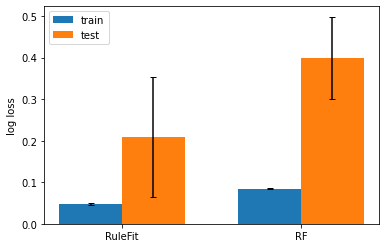

In [21]:
a.plot_summary('log loss')

In [11]:
from sklearn.model_selection import KFold

inter_no_comp = {}

for y in [data.sphere, data.vesicle, data.worm]:
    print('Target: ',y.name)
    experiment = Experiment([rufit, rf], 
            ['RuleFit', 'RF'],
            Splitdata(data.x, points, rep=2, frac=0.5),
            data.x, y.replace(-1.0, 0.0), # 
            groups=None,
            evaluators=['accuracy', LogLikelihoodEvaluator(2, neg=True)],
            verbose=True).run()
    inter_no_comp[y.name] = experiment.run()
    print()

Target:  sphere
Running experiment with 2 repetitions
**
Running experiment with 2 repetitions
**

Target:  vesicle
Running experiment with 2 repetitions
**
Running experiment with 2 repetitions
**

Target:  worm
Running experiment with 2 repetitions
**
Running experiment with 2 repetitions
**



In [40]:
inter_no_comp['sphere'].summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
RuleFit,0.997368,0.001241,0.954545,0.064282,0.047217,0.003011,0.206384,0.199755
RF,1.000000,0.000000,0.909091,0.128565,0.084673,0.001053,0.399145,0.140472


In [41]:
inter_no_comp['vesicle'].summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
RuleFit,1.0,0.0,0.886364,0.032141,0.034109,0.001379,0.510571,0.007840
RF,1.0,0.0,0.818182,0.128565,0.073917,0.002289,0.425572,0.194948


In [42]:
inter_no_comp['worm'].summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
RuleFit,0.999123,0.001241,0.750000,0.224989,0.039299,0.000734,1.196543,1.137874
RF,1.000000,0.000000,0.818182,0.257130,0.078794,0.001730,0.531823,0.384689


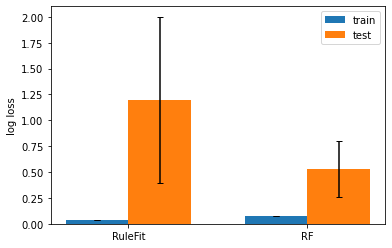

In [43]:
inter_no_comp['worm'].plot_summary('log loss')

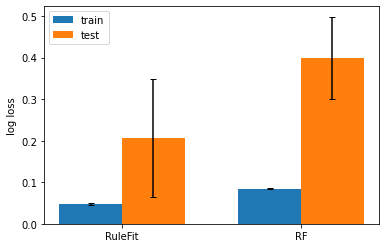

In [44]:
inter_no_comp['sphere'].plot_summary('log loss')

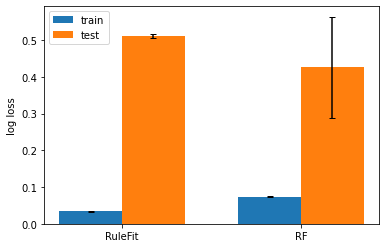

In [45]:
inter_no_comp['vesicle'].plot_summary('log loss')